# 3 Helper File

This week, you must use the python script from studip (04 svhn-helper.py) to read-in the data. The script converts the data into gray-scale images, splits the data into a training and validation dataset and provides a class to loop over the respective mini-batches. Be fair to the other groups and do not use the test dataset from the SVHN homepage to optimize your network.

In [6]:
import os
import numpy as np
import scipy.io as scio

class SVHN():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = np.array([])
        self._training_labels = np.array([])
        self._test_data = np.array([])
        self._test_labels = np.array([])
        
        self._load_traing_data()
        #self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    
    def _load_traing_data(self):
        self._training_data, self._training_labels = self._load_data("train_32x32.mat")        
    
    def _load_test_data(self):
        self._test_data, self._test_labels = self._load_data("test_32x32.mat")
    
    def _rgb2gray(self, rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    def _load_data(self, file):
        path = os.path.join(self._directory, file)
        
        mat = scio.loadmat(path)
        data = np.moveaxis(mat["X"], 3, 0)
        data = self._rgb2gray(data)
        data = data.reshape(data.shape + (1,))
        
        labels = mat["y"].reshape(mat["y"].shape[0])
        labels[labels == 10] = 0
        
        return data, labels
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    #def get_test_batch(self, batch_size):
    #    return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    


# 4 Investigate the data

As always, before you start, get an idea about how the data looks like, how the batches are structured and if the labels are assigned correctly.

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib notebook

svhn = SVHN()

<IPython.core.display.Javascript object>


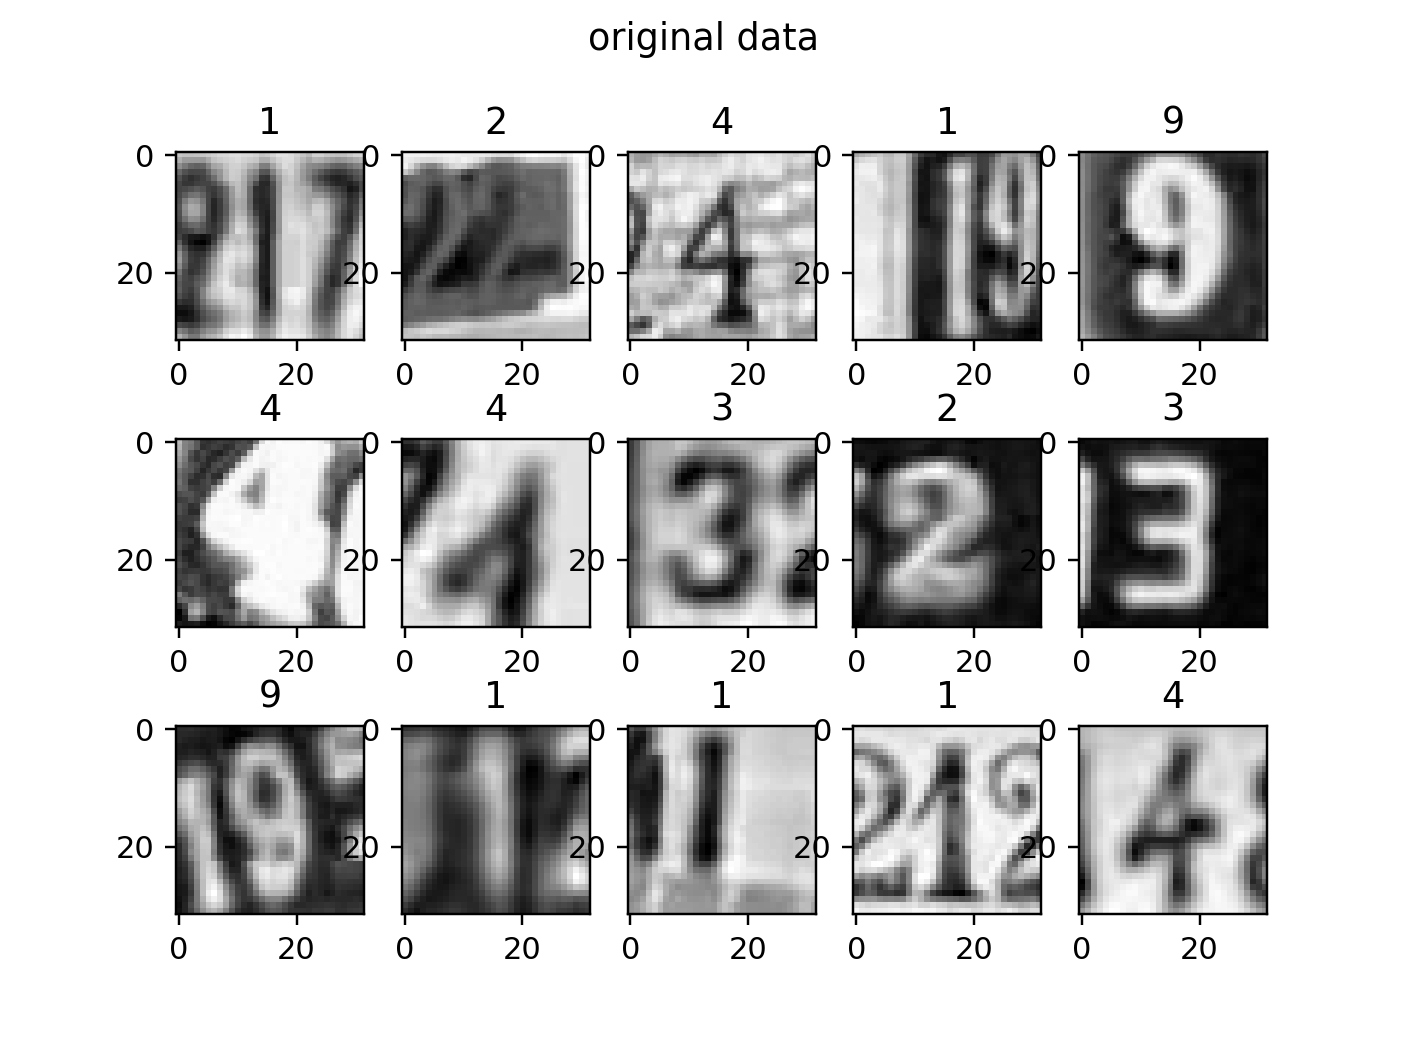

<IPython.core.display.Javascript object>


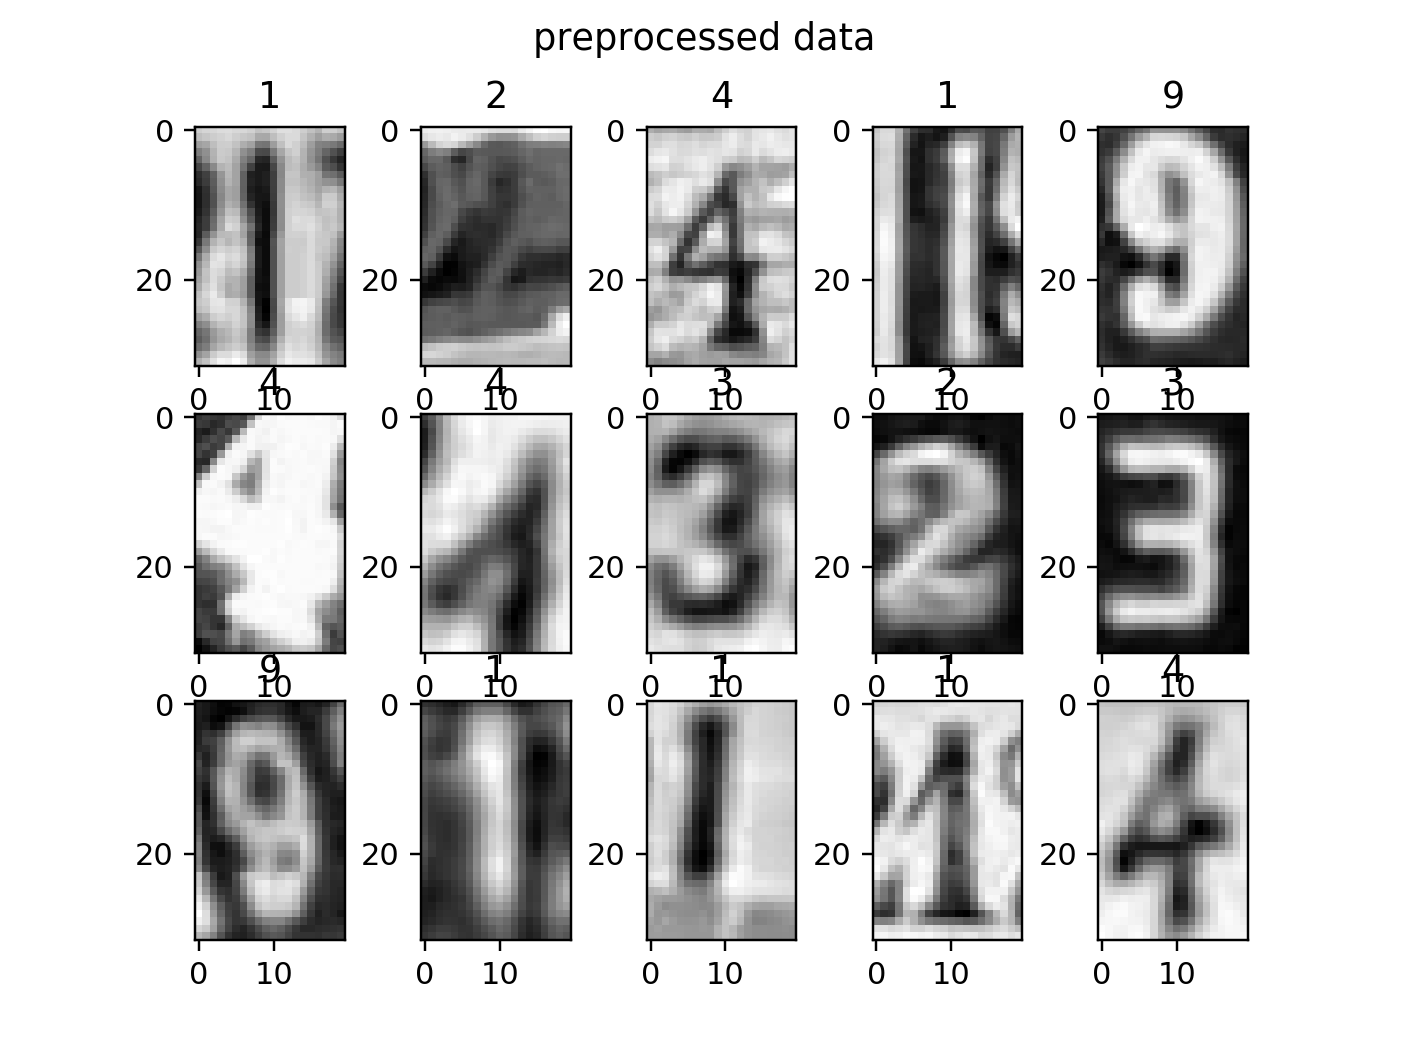

<function matplotlib.pyplot.show>

In [8]:
# retrieve training batch
images, label = next(svhn.get_training_batch(15))

# creating plot
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(np.squeeze(images[i,:,:,:]), cmap = 'gray')
    ax.set_title(str(label[i]))
plt.suptitle('original data')
plt.show

# how the data looks like after we preprocessed it (cut off the sides)
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(np.squeeze(images[i,:,6:-6,:]), cmap = 'gray')  # this is how we will preprocess out data
    ax.set_title(str(label[i]))
plt.suptitle('preprocessed data')    
plt.show

# 9 Evaluation

Please add the code of 04 svhn-evaluation.py, which can be found on studip, to the end of your ipython notebook and add any further placeholder values (i.e. a dropout rate) that you would like to feed to your network. This part of your submission will be used to evaluate the performance of your network.

In [ ]:
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session,  tf.train.latest_checkpoint("./weights/"))
    
    test_accuracy = 0
    for step, (images, labels) in enumerate(svhn.get_test_batch(300)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {x: images, desired: labels}
        )
    
print("Test Accuracy: " + str(test_accuracy / step))